In [1]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials
import time
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import openai
import pandas as pd
import redis

from langchain.vectorstores import Redis
from langchain.embeddings import OpenAIEmbeddings
from langchain.chat_models import AzureChatOpenAI
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage

from langchain.document_loaders import PyPDFLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [2]:
# define our Microsoft Cognitive Services subscription key
SUBSCRIPTION_KEY = "11c0ce07c68d4bec86d72364155c0995"
# define the ACS endpoint
ENDPOINT_URL = "https://computer-vision-1.cognitiveservices.azure.com/"

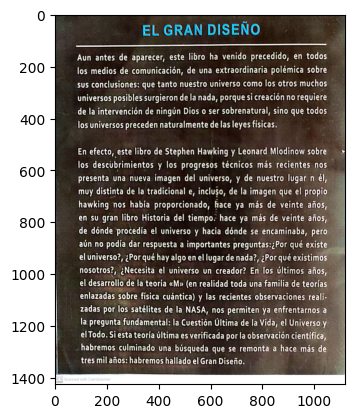

In [3]:
imate_doc_01 = '../Data/demo.jpeg'
#imate_doc_01 = '../Data/doc_01.jpg'

imate_doc_01_bgr = cv2.imread(imate_doc_01)
imate_doc_01_data = open(imate_doc_01, "rb")
plt.imshow(cv2.cvtColor(imate_doc_01_bgr, cv2.COLOR_BGR2RGB))

In [4]:
cv_client = ComputerVisionClient(ENDPOINT_URL, CognitiveServicesCredentials(SUBSCRIPTION_KEY))

In [5]:
response = cv_client.read_in_stream(imate_doc_01_data, language="es", raw=True)

In [6]:
operationLocation = response.headers["Operation-Location"]

In [7]:
operationID = operationLocation.split("/")[-1]

In [8]:
results = cv_client.get_read_result(operationID)

In [9]:
results.status == OperationStatusCodes.succeeded

True

In [10]:
read_results = results.analyze_result.read_results

In [11]:
for result in read_results:
    
    for line in result.lines:
    
        print(line.text)
        print(line.bounding_box)
        print("*"*10)

EL GRAN DISEÑO
[330.0, 34.0, 792.0, 24.0, 793.0, 84.0, 330.0, 91.0]
**********
Aun antes de aparecer, este libro ha venido precedido, en todos
[81.0, 149.0, 1049.0, 142.0, 1050.0, 181.0, 81.0, 189.0]
**********
los medios de comunicación, de una extraordinaria polémica sobre
[81.0, 198.0, 1051.0, 193.0, 1051.0, 236.0, 81.0, 239.0]
**********
sus conclusiones: que tanto nuestro universo como los otros muchos
[80.0, 253.0, 1049.0, 248.0, 1050.0, 286.0, 80.0, 293.0]
**********
universos posibles surgieron de la nada, porque si creación no requiere
[82.0, 302.0, 1050.0, 299.0, 1050.0, 342.0, 82.0, 345.0]
**********
de la intervención de ningún Dios o ser sobrenatural, sino que todos
[82.0, 354.0, 1048.0, 352.0, 1048.0, 395.0, 82.0, 397.0]
**********
los universos preceden naturalmente de las leyes físicas.
[85.0, 407.0, 860.0, 404.0, 860.0, 446.0, 85.0, 449.0]
**********
En efecto, este libro de Stephen Hawking y Leonard Mlodinow sobre
[83.0, 509.0, 1049.0, 507.0, 1049.0, 551.0, 83.0, 554.

In [12]:
results.as_dict()

{'status': 'succeeded',
 'created_date_time': '2023-05-31T20:21:39Z',
 'last_updated_date_time': '2023-05-31T20:21:40Z',
 'analyze_result': {'version': '3.2.0',
  'model_version': '2022-04-30',
  'read_results': [{'page': 1,
    'language': 'es',
    'angle': 0.1191,
    'width': 1118.0,
    'height': 1425.0,
    'unit': 'pixel',
    'lines': [{'bounding_box': [330.0,
       34.0,
       792.0,
       24.0,
       793.0,
       84.0,
       330.0,
       91.0],
      'appearance': {'style': {'name': 'other', 'confidence': 0.972}},
      'text': 'EL GRAN DISEÑO',
      'words': [{'bounding_box': [332.0,
         38.0,
         393.0,
         35.0,
         393.0,
         90.0,
         331.0,
         91.0],
        'text': 'EL',
        'confidence': 0.998},
       {'bounding_box': [409.0, 35.0, 558.0, 30.0, 559.0, 87.0, 409.0, 90.0],
        'text': 'GRAN',
        'confidence': 0.991},
       {'bounding_box': [578.0, 29.0, 780.0, 25.0, 781.0, 85.0, 579.0, 87.0],
        'text': 'DI

In [36]:
def get_text_from_image_file(image_file_route, language="es"):
    
    image_data = open(image_file_route, "rb")    
    
    #client = ComputerVisionClient(ENDPOINT_URL, CognitiveServicesCredentials(SUBSCRIPTION_KEY))
    response = cv_client.read_in_stream(image_data, language=language, raw=True)
    
    operationLocation = response.headers["Operation-Location"]
    operationID = operationLocation.split("/")[-1]
    
    output = ''
    
    while True:
        # get the result
        results = cv_client.get_read_result(operationID)

        # check if the status is not "not started" or "running", if so,
        # stop the polling operation
        if results.status.lower() not in ["notstarted", "running"]:
            break

        # sleep for a bit before we make another request to the API
        time.sleep(2)
    
    if results.status == OperationStatusCodes.succeeded:
        
        read_results = results.analyze_result.read_results
        
        for result in read_results:
            for line in result.lines:
                output = output + line.text + " "
    
        return output
    
    else:
        return False

In [37]:
text_scanner = get_text_from_image_file(imate_doc_01)

In [38]:
text_scanner

'EL GRAN DISEÑO Aun antes de aparecer, este libro ha venido precedido, en todos los medios de comunicación, de una extraordinaria polémica sobre sus conclusiones: que tanto nuestro universo como los otros muchos universos posibles surgieron de la nada, porque si creación no requiere de la intervención de ningún Dios o ser sobrenatural, sino que todos los universos preceden naturalmente de las leyes físicas. En efecto, este libro de Stephen Hawking y Leonard Mlodinow sobre los descubrimientos y los progresos técnicos más recientes nos presenta una nueva imagen del universo, y de nuestro lugar n él, muy distinta de la tradicional e, incluso, de la imagen que el propio hawking nos había proporcionado, hace ya más de veinte años, en su gran libro Historia del tiempo. hace ya más de veinte años, de dónde procedía el universo y hacia dónde se encaminaba, pero aún no podía dar respuesta a importantes preguntas :¿ Por qué existe el universo ?, ¿ Por qué hay algo en el lugar de nada ?, ¿ Por qu

In [16]:
temp_txt_route = imate_doc_01 + ".doc"
text_file = open(temp_txt_route, "w")
#write string to file
text_file.write(text_scanner)
#close file
text_file.close()


loader = TextLoader(temp_txt_route)

chunk_size = 1024
chunk_overlap = 200

text_splitter = RecursiveCharacterTextSplitter(        
    chunk_size = chunk_size,
    chunk_overlap  = chunk_overlap,
    length_function = len,
)

pages = loader.load_and_split(text_splitter)


os.remove(temp_txt_route)

In [23]:
pages

[Document(page_content='EL GRAN DISEÑO Aun antes de aparecer, este libro ha venido precedido, en todos los medios de comunicación, de una extraordinaria polémica sobre sus conclusiones: que tanto nuestro universo como los otros muchos universos posibles surgieron de la nada, porque si creación no requiere de la intervención de ningún Dios o ser sobrenatural, sino que todos los universos preceden naturalmente de las leyes físicas. En efecto, este libro de Stephen Hawking y Leonard Mlodinow sobre los descubrimientos y los progresos técnicos más recientes nos presenta una nueva imagen del universo, y de nuestro lugar n él, muy distinta de la tradicional e, incluso, de la imagen que el propio hawking nos había proporcionado, hace ya más de veinte años, en su gran libro Historia del tiempo. hace ya más de veinte años, de dónde procedía el universo y hacia dónde se encaminaba, pero aún no podía dar respuesta a importantes preguntas :¿ Por qué existe el universo ?, ¿ Por qué hay algo en el lu

In [24]:
pages[0]

Document(page_content='EL GRAN DISEÑO Aun antes de aparecer, este libro ha venido precedido, en todos los medios de comunicación, de una extraordinaria polémica sobre sus conclusiones: que tanto nuestro universo como los otros muchos universos posibles surgieron de la nada, porque si creación no requiere de la intervención de ningún Dios o ser sobrenatural, sino que todos los universos preceden naturalmente de las leyes físicas. En efecto, este libro de Stephen Hawking y Leonard Mlodinow sobre los descubrimientos y los progresos técnicos más recientes nos presenta una nueva imagen del universo, y de nuestro lugar n él, muy distinta de la tradicional e, incluso, de la imagen que el propio hawking nos había proporcionado, hace ya más de veinte años, en su gran libro Historia del tiempo. hace ya más de veinte años, de dónde procedía el universo y hacia dónde se encaminaba, pero aún no podía dar respuesta a importantes preguntas :¿ Por qué existe el universo ?, ¿ Por qué hay algo en el lug

In [25]:
len(pages)

2

In [26]:
api_type = "azure"
api_base_url = "https://openaidemonubiral.openai.azure.com/"
api_version = "2023-03-15-preview"
azure_api_key = "ff5c606c134e4d1dae3426a412df834a"

openai.api_type = api_type
openai.api_base = api_base_url
openai.api_version = api_version
openai.api_key = azure_api_key

os.environ["OPENAI_API_BASE"] = api_base_url
os.environ["OPENAI_API_KEY"] = azure_api_key

#openai.Deployment.list()

embeddings_azure = OpenAIEmbeddings(model="text-embedding-ada-002", chunk_size=1)

llm_azure_chatgpt = AzureChatOpenAI(
    deployment_name="nubiral-lab-01", 
    temperature=0, 
    openai_api_version=api_version)

In [28]:
redis_url = "rediss://:7faRnxC4vBcEWoGNuB9hN6gnXxdYpdRtM5KhcGRq0d8=@vectordb.eastus2.redisenterprise.cache.azure.net:10000"
index_name = 'test_01'

rds = Redis.from_documents(pages, embeddings_azure, redis_url=redis_url,  index_name=index_name)

In [29]:
k=5
retriever_db = rds.as_retriever(search_type="similarity", search_kwargs={"k": k})

In [30]:
chain_type = "stuff"

qa = RetrievalQA.from_chain_type(llm=llm_azure_chatgpt, chain_type=chain_type, retriever=retriever_db, return_source_documents=True)

In [31]:
query = "quienes son los autores?"
result = qa({"query": query})

In [32]:
result['result']

'Los autores del libro son Stephen Hawking y Leonard Mlodinow.'

In [33]:
result['source_documents']

[Document(page_content='EL GRAN DISEÑO Aun antes de aparecer, este libro ha venido precedido, en todos los medios de comunicación, de una extraordinaria polémica sobre sus conclusiones: que tanto nuestro universo como los otros muchos universos posibles surgieron de la nada, porque si creación no requiere de la intervención de ningún Dios o ser sobrenatural, sino que todos los universos preceden naturalmente de las leyes físicas. En efecto, este libro de Stephen Hawking y Leonard Mlodinow sobre los descubrimientos y los progresos técnicos más recientes nos presenta una nueva imagen del universo, y de nuestro lugar n él, muy distinta de la tradicional e, incluso, de la imagen que el propio hawking nos había proporcionado, hace ya más de veinte años, en su gran libro Historia del tiempo. hace ya más de veinte años, de dónde procedía el universo y hacia dónde se encaminaba, pero aún no podía dar respuesta a importantes preguntas :¿ Por qué existe el universo ?, ¿ Por qué hay algo en el lu